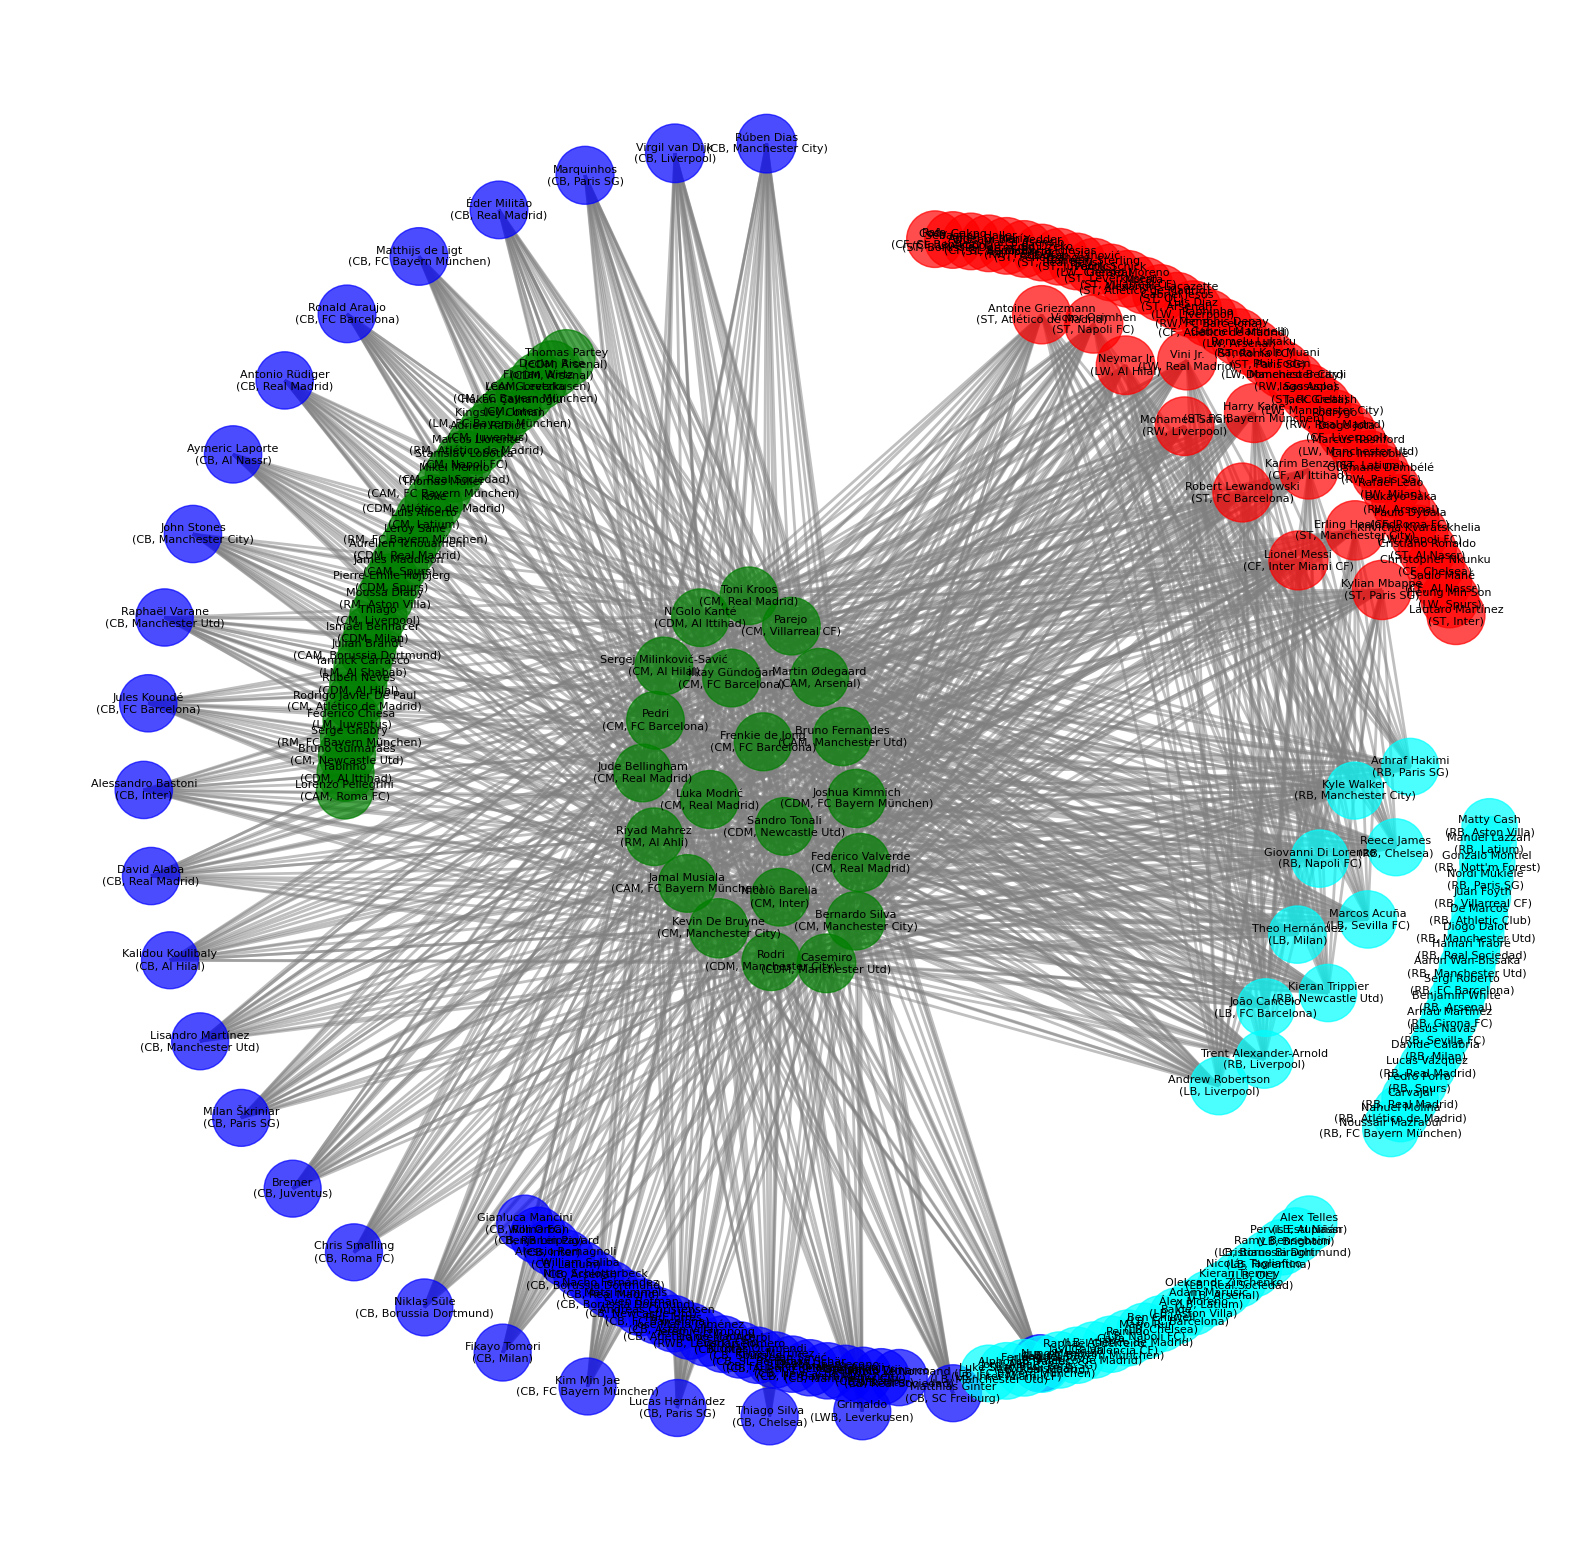

O grafo tem 1097 arestas.


In [16]:
# Importando as bibliotecas necessárias
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.optimize

# Carregar o arquivo CSV filtrado em um DataFrame
filtered_csv_path = 'top_players_filtered.csv'
players_data = pd.read_csv(filtered_csv_path)

# Criar um grafo vazio
G = nx.Graph()

# Adicionar cada jogador como um nó no grafo
for index, row in players_data.iterrows():
    G.add_node(row['Name'], position=row['Position'], overall=row['Overall'], club=row['Club'])

# Categorias e seus respectivos thresholds
thresholds = {
    'Atacantes': 88,
    'Meias': 86,
    'Zagueiros': 84,
    'Laterais': 84
}

# Política de conexões baseada na lógica tática
connection_policy = {
    'Atacantes': ['Meias', 'Laterais'],  # Atacantes frequentemente recebem passes dos meias e laterais
    'Meias': ['Atacantes', 'Zagueiros', 'Laterais'],  # Meias conectam o jogo entre a defesa e o ataque, e colaboram com os laterais
    'Zagueiros': ['Meias'],  # Zagueiros normalmente passam a bola para os meias
    'Laterais': ['Meias', 'Atacantes']  # Laterais apoiam o ataque e frequentemente interagem com meias e atacantes
}

# Mapeamento das posições específicas para suas categorias
position_to_category = {
    'ST': 'Atacantes', 'CF': 'Atacantes', 'LW': 'Atacantes', 'RW': 'Atacantes',
    'CDM': 'Meias', 'CM': 'Meias', 'RM': 'Meias', 'LM': 'Meias', 'CAM': 'Meias',
    'CB': 'Zagueiros', 'RWB': 'Zagueiros', 'LWB': 'Zagueiros',
    'LB': 'Laterais', 'RB': 'Laterais',
}

# Adicionando arestas com base na política de conexões e thresholds
for player1 in G.nodes():
    for player2 in G.nodes():
        if player1 != player2:  # Evita autoconexão
            player1_category = position_to_category[G.nodes[player1]['position']]
            player2_category = position_to_category[G.nodes[player2]['position']]
            if player2_category in connection_policy[player1_category]:  # Verifica compatibilidade de posição
                if G.nodes[player1]['overall'] >= thresholds[player1_category] and G.nodes[player2]['overall'] >= thresholds[player2_category]:  # Verifica thresholds de 'Overall'
                    G.add_edge(player1, player2)  # Cria a aresta se ambas condições forem atendidas

# Mapeando cada posição para uma cor
position_colors = {
    'Atacantes': 'red',
    'Meias': 'green',
    'Zagueiros': 'blue',
    'Laterais': 'cyan'  # Alterei para ciano para melhor contraste
}

# Aplicando as cores de posição aos nós
node_colors = [position_colors[position_to_category[G.nodes[node]['position']]] for node in G]

# Configuração para a visualização do grafo
plt.figure(figsize=(20, 20))
pos = nx.kamada_kawai_layout(G)

# Desenhando os nós e arestas
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='grey')
node_sizes = [G.nodes[node]['overall'] * 20 for node in G.nodes()]  # Ajustando o tamanho dos nós
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.7)

# Desenhando os rótulos (nome e clube)
labels = {node: f"{node}\n({G.nodes[node]['position']}, {G.nodes[node]['club']})" for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black', verticalalignment='center')

# plt.title("Grafo de Interações entre Jogadores por Posição", size=35)
plt.axis('off')
plt.show()

# Verifique se as arestas foram criadas
print(f"O grafo tem {G.number_of_edges()} arestas.")

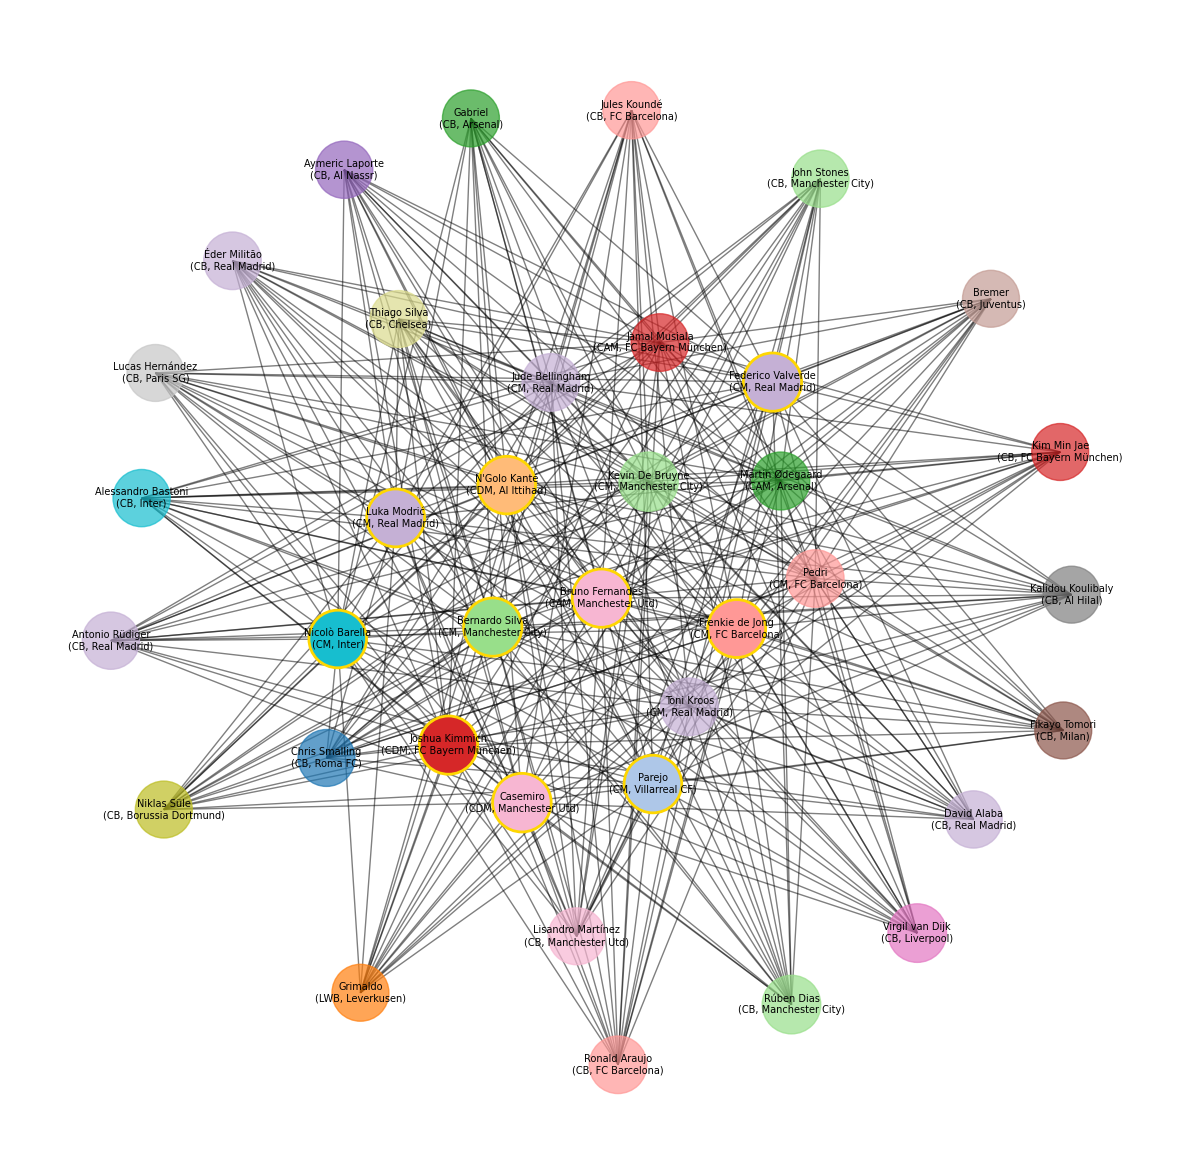

Clubes dos Top k Jogadores: ['Manchester Utd', 'Inter', 'Real Madrid', 'Manchester Utd', 'Manchester City', 'FC Barcelona', 'Al Ittihad', 'Villarreal CF', 'FC Bayern München', 'Real Madrid']


In [17]:
import matplotlib.pyplot as plt
import networkx as nx
import scipy.optimize
from networkx.algorithms.community import greedy_modularity_communities

# Detectando comunidades com o algoritmo greedy_modularity_communities
communities = greedy_modularity_communities(G, weight='weight')

# Identificando o maior cluster
largest_community = max(communities, key=len)

# Criando um subgrafo para o maior cluster
largest_community_subgraph = G.subgraph(largest_community)

# Calculando a centralidade de grau para o maior cluster
degree_centrality_largest = nx.degree_centrality(largest_community_subgraph)

# Selecionando os 'top k' jogadores mais conectados dentro do maior cluster
k = 10  # Define o número de jogadores top para análise
top_k_players = sorted(degree_centrality_largest, key=degree_centrality_largest.get, reverse=True)[:k]

# Gerando um mapeamento de cores para cada clube presente no maior cluster
unique_clubs_largest = set(nx.get_node_attributes(largest_community_subgraph, 'club').values())
club_to_color = {club: plt.cm.tab20(i / len(unique_clubs_largest)) for i, club in enumerate(unique_clubs_largest)}

# Aplicando as cores aos nós do maior cluster
node_colors_largest = [club_to_color[largest_community_subgraph.nodes[node]['club']] for node in largest_community_subgraph.nodes()]

# Ajuste de tamanho dos nós com base no 'overall'
node_sizes_largest = [largest_community_subgraph.nodes[node]['overall'] * 20 for node in largest_community_subgraph.nodes()]

# Visualização do maior cluster
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(largest_community_subgraph, k=1.0, iterations=20)  # Posicionamento dos nós do maior cluster
nx.draw_networkx_nodes(largest_community_subgraph, pos, node_size=node_sizes_largest, node_color=node_colors_largest, alpha=0.7)
nx.draw_networkx_edges(largest_community_subgraph, pos, alpha=0.5)

# Desenhando os rótulos dos nós com o nome, posição e clube para o maior cluster
labels_largest = {node: f"{node}\n({largest_community_subgraph.nodes[node]['position']}, {largest_community_subgraph.nodes[node]['club']})" for node in largest_community_subgraph.nodes()}
nx.draw_networkx_labels(largest_community_subgraph, pos, labels=labels_largest, font_size=7, font_color='black', verticalalignment='center')

# Destacando os 'top k' jogadores com uma borda dourada
top_k_node_colors = [club_to_color[largest_community_subgraph.nodes[node]['club']] for node in top_k_players]
nx.draw_networkx_nodes(largest_community_subgraph, pos, nodelist=top_k_players, node_size=[largest_community_subgraph.nodes[node]['overall'] * 20 for node in top_k_players], node_color=top_k_node_colors, edgecolors='gold', linewidths=2)

# plt.title("Top k Jogadores no Maior Cluster")
plt.axis('off')
plt.show()

# Análise das afiliações de clube dos 'top k' jogadores
top_k_clubs = [largest_community_subgraph.nodes[player]['club'] for player in top_k_players]
print("Clubes dos Top k Jogadores:", top_k_clubs)